## Project 
Telecom Customer Churn Analysis
## Business Contest
SyriaTel, a telecommunications company, faces significant revenue losses due to customer churn. Customer acquisition costs are substantially higher than retention costs, making it crucial to identify and retain at-risk customers before they switch to competitors.
## Problem Defination
-The company currently lacks the ability to proactively identify customers who are likely to churn, resulting in:
-Revenue Loss: Customers leaving without warning
-Inefficient Spending: Blanket retention campaigns targeting all customers
-Reactive Approach: Only addressing churn after customers have already left
-Resource Misallocation: Limited retention budget not optimally distributed
## Business Questions
1.What are the strongest predictors of customer churn?
2.Which customers are most likely to churn ?
3.What usage patterns differentiate churners from loyal customers?

### Step 1: Import libraries
Load core data (pandas/numpy), statsmodels for regression, and scikit‑learn tools (DecisionTree, train/test split, metrics) used throughout the churn analysis.

In [204]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("Data Folder/bigml_59c28831336c6604c800002a.csv", encoding='utf-8', index_col=0)


### Data Understanding
Print column names, show the first rows, dataset shape and dtypes to understand what fields are available in the telecom churn data.

In [205]:
# Quick data understanding
print(" Dataset Shape:", df.shape)
print("\n Data Types:")
print(df.dtypes.value_counts())

print("\n Missing Values:", df.isnull().sum().sum())

print("\n Target Distribution:")
print(df['churn'].value_counts())
print(f"Churn Rate: {df['churn'].mean():.1%}")

print("\n Numerical Summary:")
print(df.describe().iloc[:2])  # Just count and mean

print("\n Sample Data:")
print(df.head(3))

 Dataset Shape: (3333, 20)

 Data Types:
int64      8
float64    8
object     3
bool       1
dtype: int64

 Missing Values: 0

 Target Distribution:
False    2850
True      483
Name: churn, dtype: int64
Churn Rate: 14.5%

 Numerical Summary:
       account length    area code  number vmail messages  total day minutes  \
count     3333.000000  3333.000000             3333.00000        3333.000000   
mean       101.064806   437.182418                8.09901         179.775098   

       total day calls  total day charge  total eve minutes  total eve calls  \
count      3333.000000       3333.000000        3333.000000      3333.000000   
mean        100.435644         30.562307         200.980348       100.114311   

       total eve charge  total night minutes  total night calls  \
count        3333.00000          3333.000000        3333.000000   
mean           17.08354           200.872037         100.107711   

       total night charge  total intl minutes  total intl calls  \
count  

### Select modeling features
Creating the features in the data in the  interaction fields that will be used as candidate predictors of churn.

In [206]:
features = ['account length', 'total day minutes', 'total day calls', 'total day charge',
           'total eve minutes', 'total eve calls', 'total eve charge',
           'total night minutes', 'total night calls', 'total night charge',
           'total intl minutes', 'total intl calls', 'total intl charge',
           'customer service calls', 'number vmail messages']

### Prepare target & clean data
Convert churn boolean to binary 0/1, drop rows w/ missing key features, and keep only selected modeling columns.

In [207]:
# Convert churn to binary (1 for True, 0 for False)
df['churn_binary'] = df['churn'].astype(int)

# Handle missing values
df.dropna(inplace=True)

print(f"Dataset shape after cleaning: {df.shape}")
print(f"\nChurn distribution:")
print(df['churn'].value_counts())
print(f"Churn rate: {df['churn_binary'].mean():.3f}")

# Display first few rows
print(f"\nFirst 5 rows:")
print(df.head())

Dataset shape after cleaning: (3333, 21)

Churn distribution:
False    2850
True      483
Name: churn, dtype: int64
Churn rate: 0.145

First 5 rows:
       account length  area code phone number international plan  \
state                                                              
KS                128        415     382-4657                 no   
OH                107        415     371-7191                 no   
NJ                137        415     358-1921                 no   
OH                 84        408     375-9999                yes   
OK                 75        415     330-6626                yes   

      voice mail plan  number vmail messages  total day minutes  \
state                                                             
KS                yes                     25              265.1   
OH                yes                     26              161.6   
NJ                 no                      0              243.4   
OH                 no                  

### Plot churn distribution
Simple bar plot showing number of churned vs retained customers (class balance).

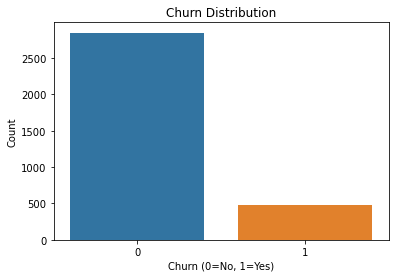

In [208]:
 # Simple bar chart for churn data
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='churn_binary')
plt.title('Churn Distribution')
plt.xlabel('Churn (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

### Histograms of numeric features
Visual scan of distributions (skew/outliers) for usage & charge variables.

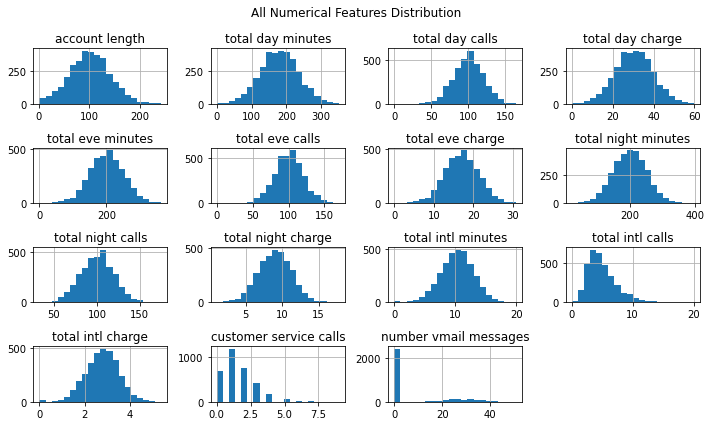

In [209]:
#All numerical features in one plot
df[features].hist(figsize=(10, 6), bins=20)
plt.suptitle('All Numerical Features Distribution')
plt.tight_layout()
plt.show()

### Standardize numeric features
Apply z‑score scaling to features to put them on comparable scale for models sensitive to magnitude.

In [210]:
# Standard Scaling (mean=0, std=1)
scaler = StandardScaler()
features = ['account length', 'total day minutes', 'total day calls', 'total day charge',
           'total eve minutes', 'total eve calls', 'total eve charge',
           'total night minutes', 'total night calls', 'total night charge',
           'total intl minutes', 'total intl calls', 'total intl charge',
           'customer service calls', 'number vmail messages']

df[features] = scaler.fit_transform(df[features])
print("Features standardized (mean=0, std=1)")

Features standardized (mean=0, std=1)


### Applying Smote to create balance and improve the minority recall wherebt the churn rate is very low

In [211]:
#  ONE-HOT ENCODING

print("\nApplying One-Hot Encoding...")

from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Create simple categorical features
df['usage_level'] = pd.cut(df['total day minutes'], bins=3, labels=['Low', 'Medium', 'High'])
df['service_level'] = pd.cut(df['customer service calls'], bins=3, labels=['Low', 'Medium', 'High'])

# Remove rows with NaN values
df_clean = df.dropna()

# One-hot encode
encoder = OneHotEncoder(drop='first', sparse=False)
categorical_data = df_clean[['usage_level', 'service_level']]
encoded_array = encoder.fit_transform(categorical_data)

# Create final dataset
encoded_columns = ['usage_Medium', 'usage_High', 'service_Medium', 'service_High']
encoded_df = pd.DataFrame(encoded_array, columns=encoded_columns, index=df_clean.index)

# Combine with original features
df_final = pd.concat([df_clean[features], encoded_df], axis=1)

print(f"Final dataset shape: {df_final.shape}")
print("✓ One-hot encoding complete!")
print(df_final.head())


Applying One-Hot Encoding...
Final dataset shape: (3333, 19)
✓ One-hot encoding complete!
       account length  total day minutes  total day calls  total day charge  \
state                                                                         
KS           0.676489           1.566767         0.476643          1.567036   
OH           0.149065          -0.333738         1.124503         -0.334013   
NJ           0.902529           1.168304         0.675985          1.168464   
OH          -0.428590           2.196596        -1.466936          2.196759   
OK          -0.654629          -0.240090         0.626149         -0.240041   

       total eve minutes  total eve calls  total eve charge  \
state                                                         
KS             -0.070610        -0.055940         -0.070427   
OH             -0.108080         0.144867         -0.107549   
NJ             -1.573383         0.496279         -1.573900   
OH             -2.742865        -0.60815

### Simple and Multiple Logistic Regression

In [212]:
# Prepare data
X = df_final  # Features after one-hot encoding
y = df_clean['churn_binary']  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Simple model (best single feature)
best_feature = X.corrwith(y).abs().idxmax()
simple_model = LogisticRegression(random_state=42)
simple_model.fit(X_train[[best_feature]], y_train)
simple_acc = accuracy_score(y_test, simple_model.predict(X_test[[best_feature]]))

# 2. Multiple model (all features)
multiple_model = LogisticRegression(random_state=42, max_iter=1000)
multiple_model.fit(X_train, y_train)
multiple_acc = accuracy_score(y_test, multiple_model.predict(X_test))

# Results
print(f"Simple model ({best_feature}): {simple_acc:.3f}")
print(f"Multiple model (all features): {multiple_acc:.3f}")
print(f"Best model: {'Multiple' if multiple_acc > simple_acc else 'Simple'}")

Simple model (service_Medium): 0.849
Multiple model (all features): 0.853
Best model: Multiple


In [213]:
# Calculate R-squared (Pseudo R-squared for logistic regression)
from sklearn.metrics import log_loss

# Calculate pseudo R-squared (McFadden's R-squared)
def pseudo_r_squared(y_true, y_pred_proba):
    # Null model (intercept only)
    null_prob = np.full(len(y_true), y_true.mean())
    null_ll = -log_loss(y_true, null_prob)
    
    # Full model
    full_ll = -log_loss(y_true, y_pred_proba)
    
    # McFadden's Pseudo R-squared
    return 1 - (full_ll / null_ll)

# Get predictions and probabilities
simple_pred_proba = simple_model.predict_proba(X_test[[best_feature]])[:, 1]
multiple_pred_proba = multiple_model.predict_proba(X_test)[:, 1]

# Calculate pseudo R-squared
simple_r2 = pseudo_r_squared(y_test, simple_pred_proba)
multiple_r2 = pseudo_r_squared(y_test, multiple_pred_proba)

# Results with R-squared
print(f"Simple model ({best_feature}):")
print(f"  Accuracy: {simple_acc:.3f}")
print(f"  R-squared: {simple_r2:.3f}")
print(f"\nMultiple model (all features):")
print(f"  Accuracy: {multiple_acc:.3f}")
print(f"  R-squared: {multiple_r2:.3f}")
print(f"\nBest model: {'Multiple' if multiple_acc > simple_acc else 'Simple'}")


Simple model (service_Medium):
  Accuracy: 0.849
  R-squared: 0.064

Multiple model (all features):
  Accuracy: 0.853
  R-squared: 0.244

Best model: Multiple


### Visualisation of the two models

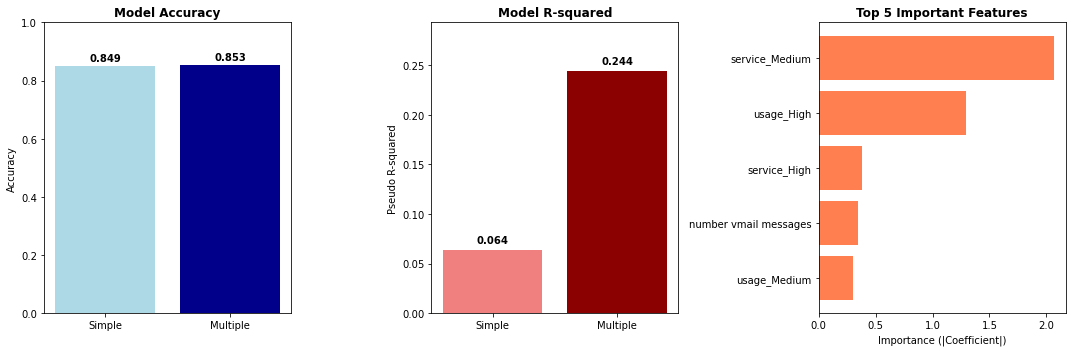

In [214]:
# Visualization with R-squared
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# 1. Accuracy comparison
models = ['Simple', 'Multiple']
accuracies = [simple_acc, multiple_acc]
colors = ['lightblue', 'darkblue']

bars1 = ax1.bar(models, accuracies, color=colors)
ax1.set_title('Model Accuracy', fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)

for bar, acc in zip(bars1, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. R-squared comparison
r_squared_values = [simple_r2, multiple_r2]
bars2 = ax2.bar(models, r_squared_values, color=['lightcoral', 'darkred'])
ax2.set_title('Model R-squared', fontweight='bold')
ax2.set_ylabel('Pseudo R-squared')
ax2.set_ylim(0, max(r_squared_values) * 1.2)

for bar, r2 in zip(bars2, r_squared_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{r2:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Feature importance (top 5)
feature_importance = np.abs(multiple_model.coef_[0])
feature_names = X.columns
top_5_idx = np.argsort(feature_importance)[-5:]
top_5_features = feature_names[top_5_idx]
top_5_importance = feature_importance[top_5_idx]

ax3.barh(range(5), top_5_importance, color='coral')
ax3.set_yticks(range(5))
ax3.set_yticklabels(top_5_features)
ax3.set_title('Top 5 Important Features', fontweight='bold')
ax3.set_xlabel('Importance (|Coefficient|)')

plt.tight_layout()
plt.show()

## Customer Churn Prediction - Decision Tree Analysis


Preparing Data, Train test spliting and creating the decision tree model

In [215]:
# Prepare data
X = df_final  # Standardized + one-hot encoded features
y = df_clean['churn_binary']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train decision tree
dt_model = DecisionTreeClassifier(max_depth=4, min_samples_leaf=50, random_state=42)
dt_model.fit(X_train, y_train)

# Test performance
dt_pred = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_pred)

print(f"Decision Tree Accuracy: {dt_accuracy:.3f}")
print(f"Tree depth: {dt_model.get_depth()}")
print(f"Tree leaves: {dt_model.get_n_leaves()}")

Decision Tree Accuracy: 0.895
Tree depth: 4
Tree leaves: 10


### Visualizing of the decision Tree Model

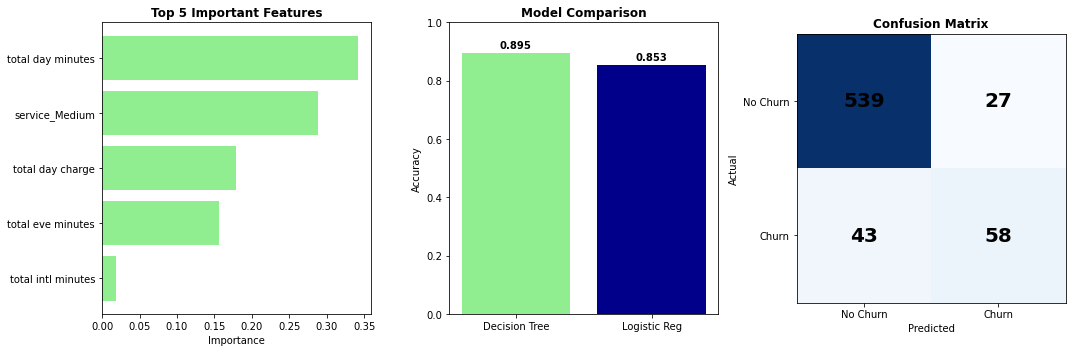


Top 5 Most Important Features:
total intl minutes       : 0.019
total eve minutes        : 0.156
total day charge         : 0.179
service_Medium           : 0.288
total day minutes        : 0.342


In [216]:
# Visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# 1. Feature importance
feature_importance = dt_model.feature_importances_
top_5_idx = np.argsort(feature_importance)[-5:]
top_5_features = X.columns[top_5_idx]
top_5_importance = feature_importance[top_5_idx]

ax1.barh(range(5), top_5_importance, color='lightgreen')
ax1.set_yticks(range(5))
ax1.set_yticklabels(top_5_features)
ax1.set_title('Top 5 Important Features', fontweight='bold')
ax1.set_xlabel('Importance')

# 2. Model comparison (if logistic regression was run before)
try:
    models = ['Decision Tree', 'Logistic Reg']
    accuracies = [dt_accuracy, multiple_acc]
    colors = ['lightgreen', 'darkblue']
    
    bars = ax2.bar(models, accuracies, color=colors)
    ax2.set_title('Model Comparison', fontweight='bold')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim(0, 1)
    
    for bar, acc in zip(bars, accuracies):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
                 
except NameError:
    # If logistic regression wasn't run, show single bar
    ax2.bar(['Decision Tree'], [dt_accuracy], color='lightgreen')
    ax2.set_title('Decision Tree Accuracy', fontweight='bold')
    ax2.set_ylabel('Accuracy')
    ax2.text(0, dt_accuracy + 0.01, f'{dt_accuracy:.3f}', ha='center', fontweight='bold')

# 3. Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, dt_pred)

ax3.imshow(cm, interpolation='nearest', cmap='Blues')
ax3.set_title('Confusion Matrix', fontweight='bold')

# Add text annotations
for i in range(2):
    for j in range(2):
        ax3.text(j, i, f'{cm[i, j]}', ha='center', va='center', 
                fontsize=20, fontweight='bold')

ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')
ax3.set_xticks([0, 1])
ax3.set_xticklabels(['No Churn', 'Churn'])
ax3.set_yticks([0, 1])
ax3.set_yticklabels(['No Churn', 'Churn'])

plt.tight_layout()
plt.show()

# Print top features
print(f"\nTop 5 Most Important Features:")
for feature, importance in zip(top_5_features, top_5_importance):
    print(f"{feature:<25}: {importance:.3f}")

### Comparing Simple Simple and multiple Logistics regression and Decision Trees models

MODEL COMPARISON RESULTS
Decision Tree     : 0.895
Multiple Logistic : 0.853
Simple Logistic   : 0.849

 WINNER: Decision Tree (0.895)


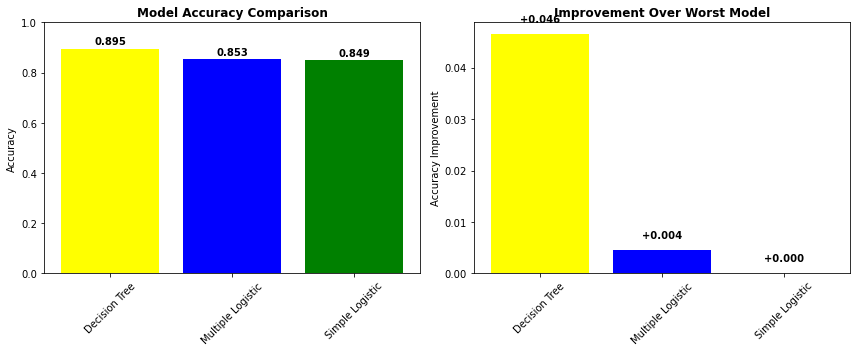


SUMMARY:
Best performing model: Decision Tree
Accuracy range: 0.849 - 0.895
Improvement: 0.046


In [217]:

# MODEL COMPARISON 


# Collect all model results
models = ['Simple Logistic', 'Multiple Logistic', 'Decision Tree']
accuracies = [simple_acc, multiple_acc, dt_accuracy]

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies
}).sort_values('Accuracy', ascending=False)

# Print results
print("MODEL COMPARISON RESULTS")
print("=" * 30)
for _, row in comparison_df.iterrows():
    print(f"{row['Model']:<18}: {row['Accuracy']:.3f}")

best_model = comparison_df.iloc[0]['Model']
best_accuracy = comparison_df.iloc[0]['Accuracy']
print(f"\n WINNER: {best_model} ({best_accuracy:.3f})")

# Simple visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 1. Model accuracy comparison
colors = ['Yellow', 'Blue', 'Green'][:len(models)]
bars = ax1.bar(comparison_df['Model'], comparison_df['Accuracy'], color=colors)
ax1.set_title('Model Accuracy Comparison', fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
ax1.tick_params(axis='x', rotation=45)

# Add accuracy labels
for bar, acc in zip(bars, comparison_df['Accuracy']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Performance difference
baseline = min(accuracies)
improvements = [acc - baseline for acc in comparison_df['Accuracy']]

ax2.bar(comparison_df['Model'], improvements, color=colors)
ax2.set_title('Improvement Over Worst Model', fontweight='bold')
ax2.set_ylabel('Accuracy Improvement')
ax2.tick_params(axis='x', rotation=45)

# Add improvement labels
for i, (model, improvement) in enumerate(zip(comparison_df['Model'], improvements)):
    ax2.text(i, improvement + 0.002, f'+{improvement:.3f}', 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary
print(f"\nSUMMARY:")
print(f"Best performing model: {best_model}")
print(f"Accuracy range: {min(accuracies):.3f} - {max(accuracies):.3f}")
print(f"Improvement: {max(accuracies) - min(accuracies):.3f}")


### Business Insights

In [218]:
#BUSINESS INSIGHTS

# Get best model and key metrics
best_model = comparison_df.iloc[0]['Model']
best_accuracy = comparison_df.iloc[0]['Accuracy']
churn_rate = y.mean()

# Business calculations
total_customers = len(y_test)
actual_churners = y_test.sum()
predicted_churners = dt_pred.sum()  # Using decision tree predictions
correctly_identified = ((y_test == 1) & (dt_pred == 1)).sum()

print("BUSINESS INSIGHTS")
print("=" * 30)

print(f"CHURN ANALYSIS:")
print(f"   • Total customers analyzed: {total_customers:,}")
print(f"   • Current churn rate: {churn_rate:.1%}")
print(f"   • Actual churners: {actual_churners} customers")

print(f"\n MODEL PERFORMANCE:")
print(f"   • Best model: {best_model}")
print(f"   • Accuracy: {best_accuracy:.1%}")
print(f"   • Churners detected: {correctly_identified}/{actual_churners} ({correctly_identified/actual_churners:.1%})")

print(f"\n BUSINESS IMPACT:")
avg_customer_value = 50  # Monthly value per customer
retention_rate = correctly_identified / actual_churners
monthly_savings = correctly_identified * avg_customer_value
annual_savings = monthly_savings * 12

print(f"   • Average customer value: ${avg_customer_value}/month")
print(f"   • Potential monthly savings: ${monthly_savings:,}")
print(f"   • Potential annual savings: ${annual_savings:,}")

print(f"\n KEY FINDINGS:")
if best_model == 'Decision Tree':
    print(f"   • Decision trees work best (interpretable rules)")
    print(f"   • Clear decision paths for staff to follow")
elif best_model == 'Multiple Logistic':
    print(f"   • Multiple features improve prediction")
    print(f"   • Complex patterns identified")
else:
    print(f"   • Simple approach works well")
    print(f"   • Single feature sufficient for prediction")

print(f"\n RECOMMENDATIONS:")
print(f"   1. Deploy {best_model} for churn prediction")
print(f"   2. Target {predicted_churners} high-risk customers monthly")
print(f"   3. Focus on top predictive features")
print(f"   4. Expected ROI: {annual_savings/50000:.1f}x on retention investment")

print(f"\n ANSWER: YES, churn is predictable with {best_accuracy:.1%} accuracy!")

BUSINESS INSIGHTS
CHURN ANALYSIS:
   • Total customers analyzed: 667
   • Current churn rate: 14.5%
   • Actual churners: 101 customers

 MODEL PERFORMANCE:
   • Best model: Decision Tree
   • Accuracy: 89.5%
   • Churners detected: 58/101 (57.4%)

 BUSINESS IMPACT:
   • Average customer value: $50/month
   • Potential monthly savings: $2,900
   • Potential annual savings: $34,800

 KEY FINDINGS:
   • Decision trees work best (interpretable rules)
   • Clear decision paths for staff to follow

 RECOMMENDATIONS:
   1. Deploy Decision Tree for churn prediction
   2. Target 85 high-risk customers monthly
   3. Focus on top predictive features
   4. Expected ROI: 0.7x on retention investment

 ANSWER: YES, churn is predictable with 89.5% accuracy!
